# Gold, Oil, NASDAQ, USD-index example

This notebook illustrates the toolkit's use on a real-world financial data set, using the weekly price of the gold, oil, the NASDAQ and an index of the USD.

For these four time series we fit three different multi-output Gaussian processes and show how they compare. For each model we optimize we repeat the experiment 5 times, to ensure robustness in the optimization and prediction.

Data sources:
- Oil: Brent daily in USD from https://www.eia.gov/dnav/pet/hist/RBRTEd.htm
- Gold: LMBA gold daily at 10:30AM in USD from https://fred.stlouisfed.org/series/GOLDAMGBD228NLBM
- NASDAQ: adjusted closing price (daily) from https://finance.yahoo.com/quote/%5EIXIC/history?p=%5EIXIC
- USD index: traded weighted on broad currency index from https://fred.stlouisfed.org/series/TWEXB

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1);

### Data loading
We will load the four financial time series and put them in a single data set for MOGPTK. Next we filter for a specific time range, in this case four years, and agregate the daily measurements into weeks. Additionally, we transform the Y axis in order to make training more effective.

For each of the channels we also remove certain ranges so that we can evaluate the effectiveness of data imputation in those regions. Each trial will additionally remove data points at random in order to verify the consistency of the results.

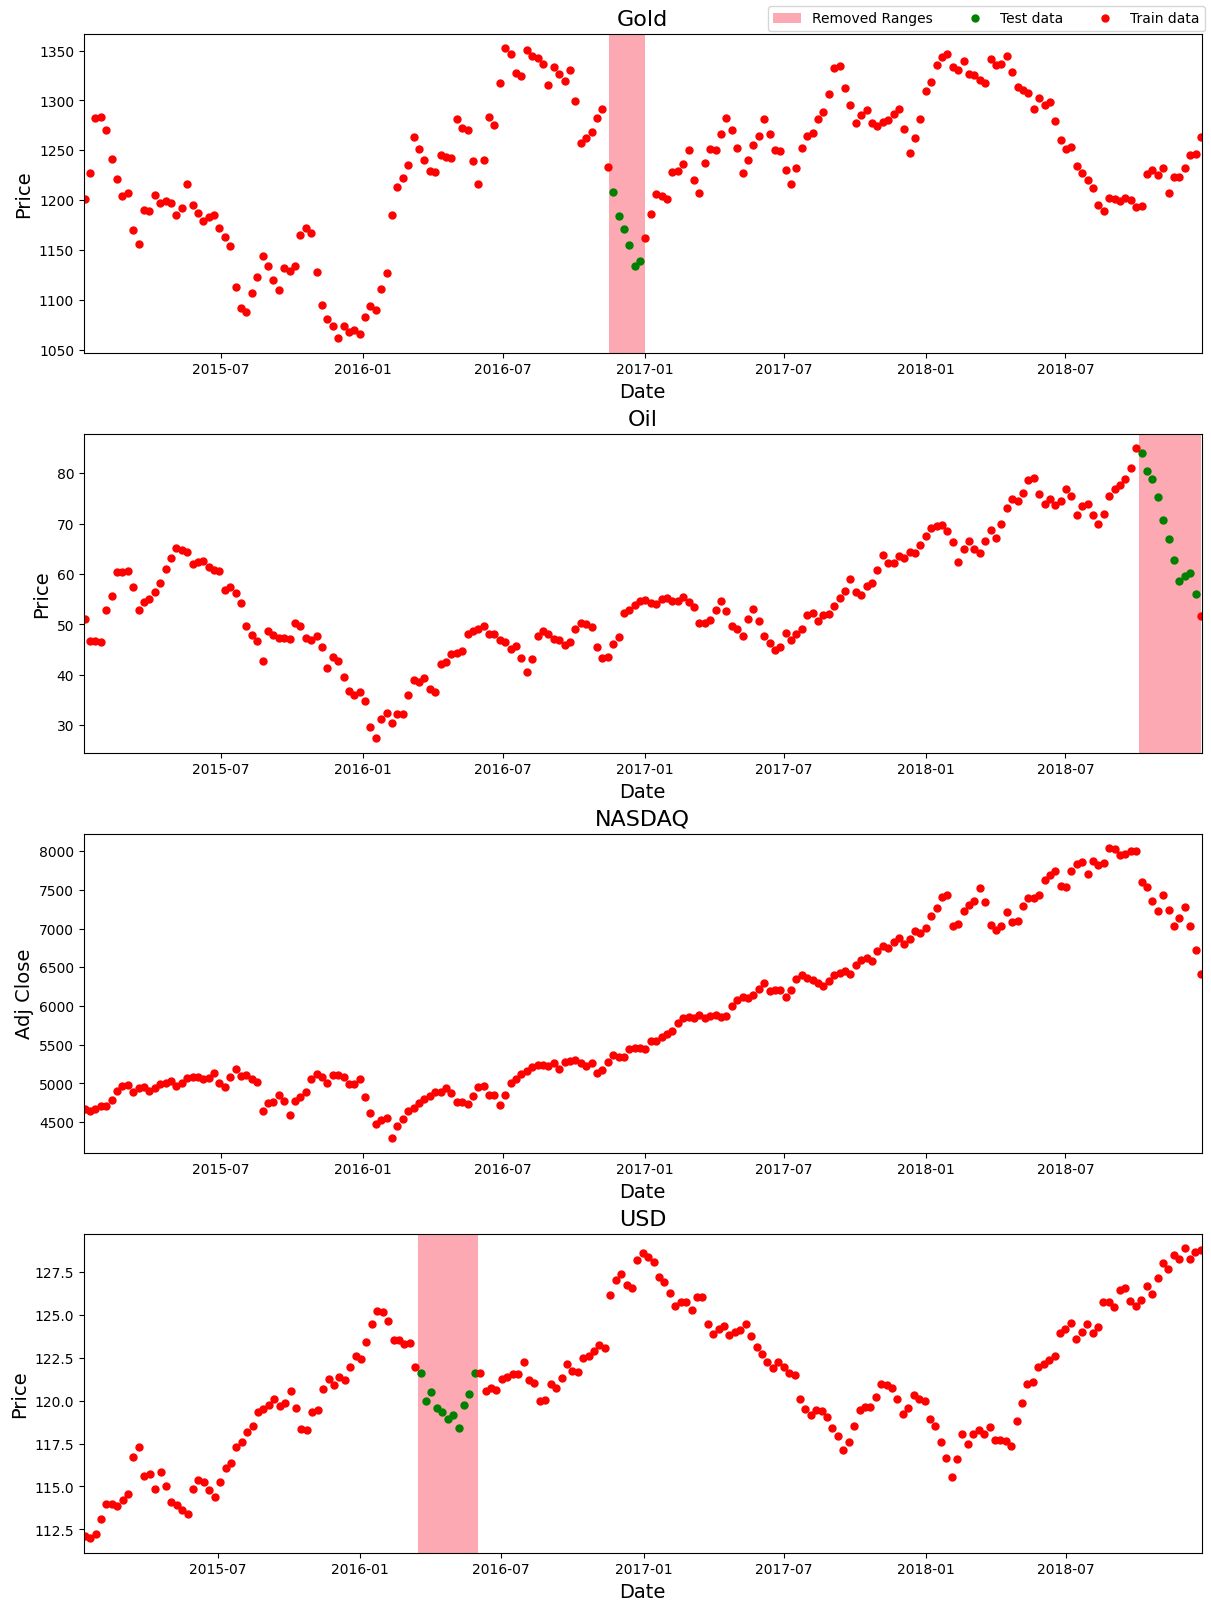

In [2]:
oil     = mogptk.LoadCSV('data/gonu/brent-daily.csv', 'Date', 'Price',
                         name='Oil')
gold    = mogptk.LoadCSV('data/gonu/lmba-gold-usd-am-daily.csv', 'Date',
                         'Price', name='Gold', na_values='.')
nasdaq  = mogptk.LoadCSV('data/gonu/nasdaq.csv', 'Date', 'Adj Close',
                         name='NASDAQ')
usd     = mogptk.LoadCSV('data/gonu/TWEXB.csv', 'Date', 'Price',
                         name='USD')
dataset = mogptk.DataSet(gold, oil, nasdaq, usd)

# Remove points randomly to simulate sensor failure
np.random.seed(1)
for i, channel in enumerate(dataset):
    channel.filter('2015-01-01', '2018-12-31')
    channel.aggregate('7D')
    
    channel.transform(mogptk.TransformDetrend())
    channel.transform(mogptk.TransformNormalize())
    
    name = channel.get_name()
    if name == 'Gold':
        channel.remove_range('2016-11-15', '2017-01-01')
    if name == 'Oil':
        channel.remove_range('2018-10-05', None)
    if name == 'USD':
        channel.remove_range('2016-03-15', '2016-06-01')

dataset.plot();

We will be using the Adam optimizer, which is known to give good results using a relatively high learning rate, and we'll run five trials for each model in order to evaluate the consistency in our results.

In [3]:
n_trials = 3
Q = 3
init_method = 'BNSE'
method = 'Adam'
lr = 0.05
iters = 1000

## Multi-output spectral mixture kernel

In [4]:
mosm_models = [None] * n_trials
mosm_mae = np.zeros((n_trials,4))
mosm_rmse = np.zeros((n_trials,4))
mosm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    mosm_dataset = dataset.copy()
    mosm_dataset['Gold'].remove_randomly(pct=0.6)
    mosm_dataset['Oil'].remove_randomly(pct=0.3)
    mosm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    mosm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=Q)
    mosm.init_parameters(init_method)

    try:
        mosm.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        mosm_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])
    mosm_models[n] = mosm


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 64
‣ Training points: 385
‣ Iterations: 1000
     0/1000   0:00:03  loss=     160.866  error=     28220.7 (warmup)
     2/1000   0:00:14  loss=     122.501  error=     15425.9
   100/1000   0:00:20  loss=    -8.77035  error=     12415.9
   318/1000   0:00:30  loss=    -66.1106  error=     12019.5
   546/1000   0:00:40  loss=    -68.4609  error=     12022.5
   772/1000   0:00:50  loss=    -69.6471  error=     11882.3
   999/1000   0:01:00  loss=    -69.4933  error=     12004.8
  1000/1000   0:01:00  loss=    -69.3814  error=     11773.1
Optimization finished in 1 minute

Trial 2 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MultiOutputSpectralMixtureKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 64
‣ Training points: 384
‣ Iterations: 1000
     0/1000   0:00:03  loss=     149.93

In [5]:
pd.DataFrame(np.c_[mosm_mae.mean(1), mosm_rmse.mean(1), mosm_mape.mean(1),
             mosm_mae.std(1), mosm_rmse.std(1), mosm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,50.230395,61.736388,3.350120,66.875186,82.469417,2.234602
1,43.191075,58.922370,2.906975,58.883457,80.646777,2.093985
2,47.818747,61.085632,2.919073,64.856768,81.591797,1.801894


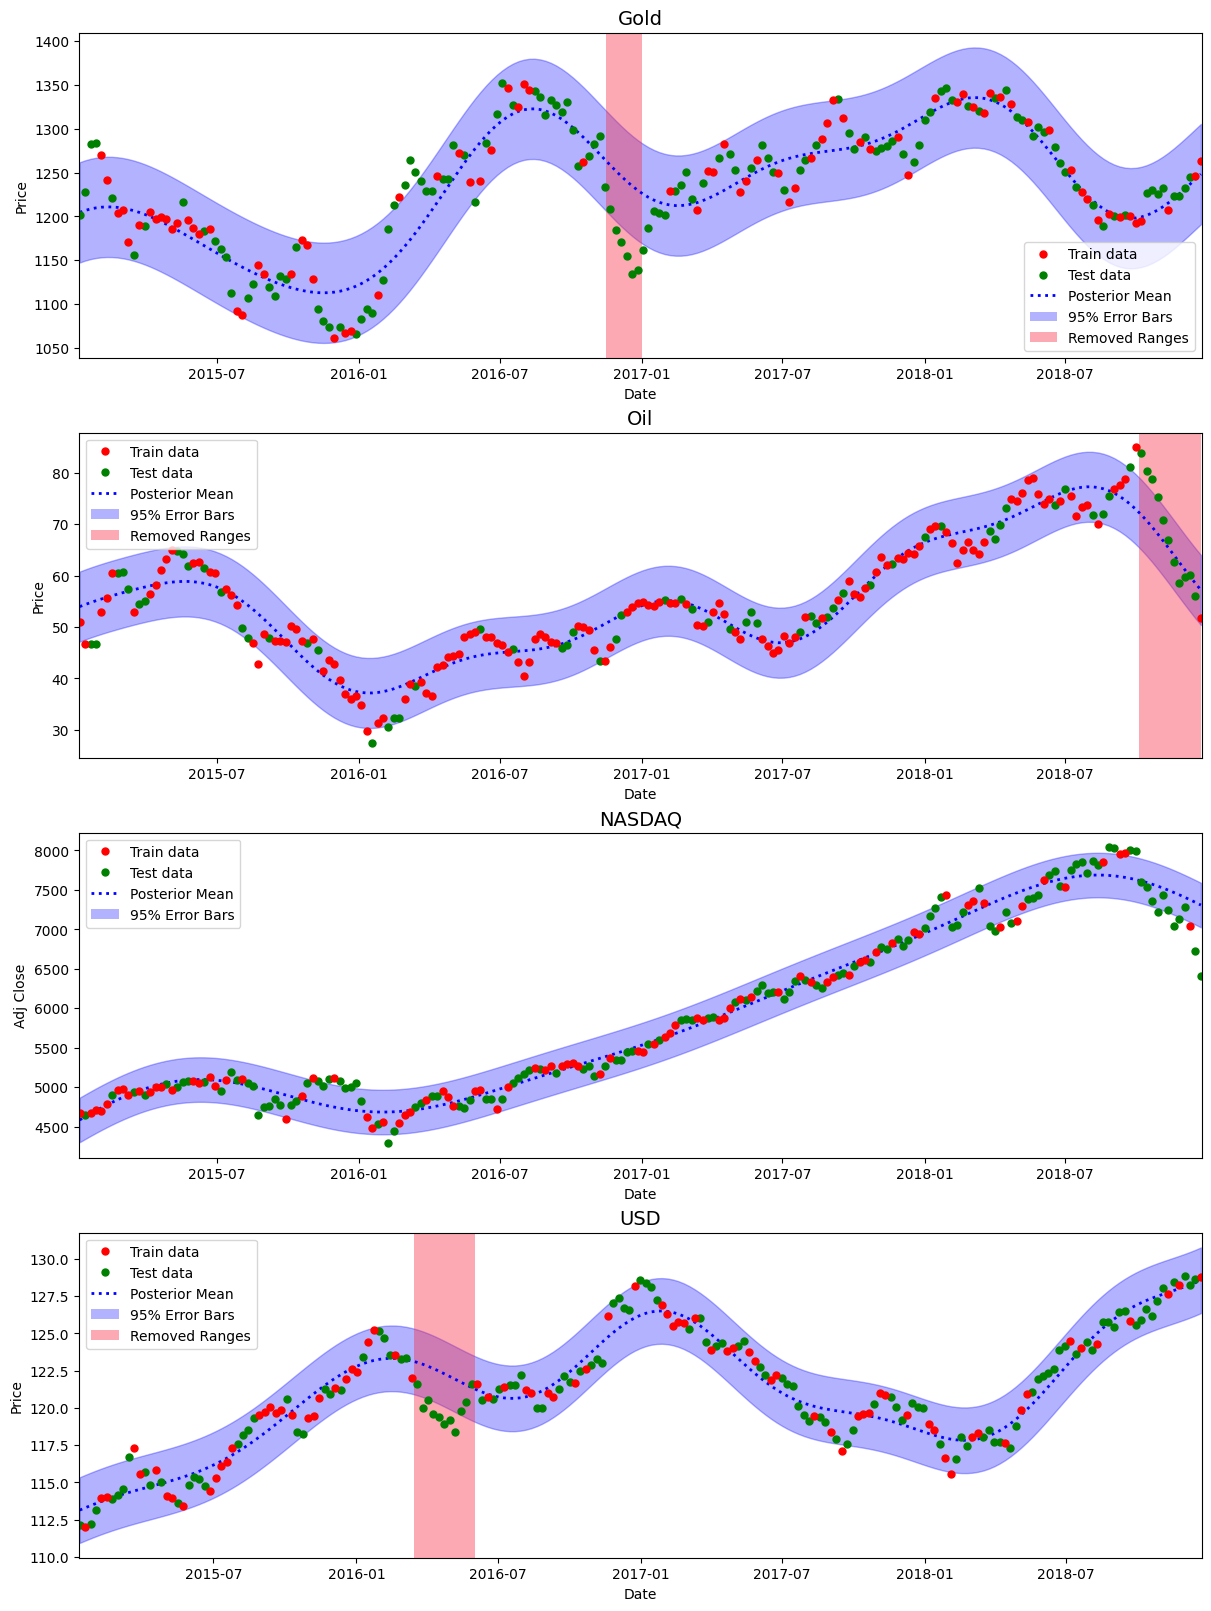

In [6]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.plot_prediction();

### Correlation of channels evaluated at zero

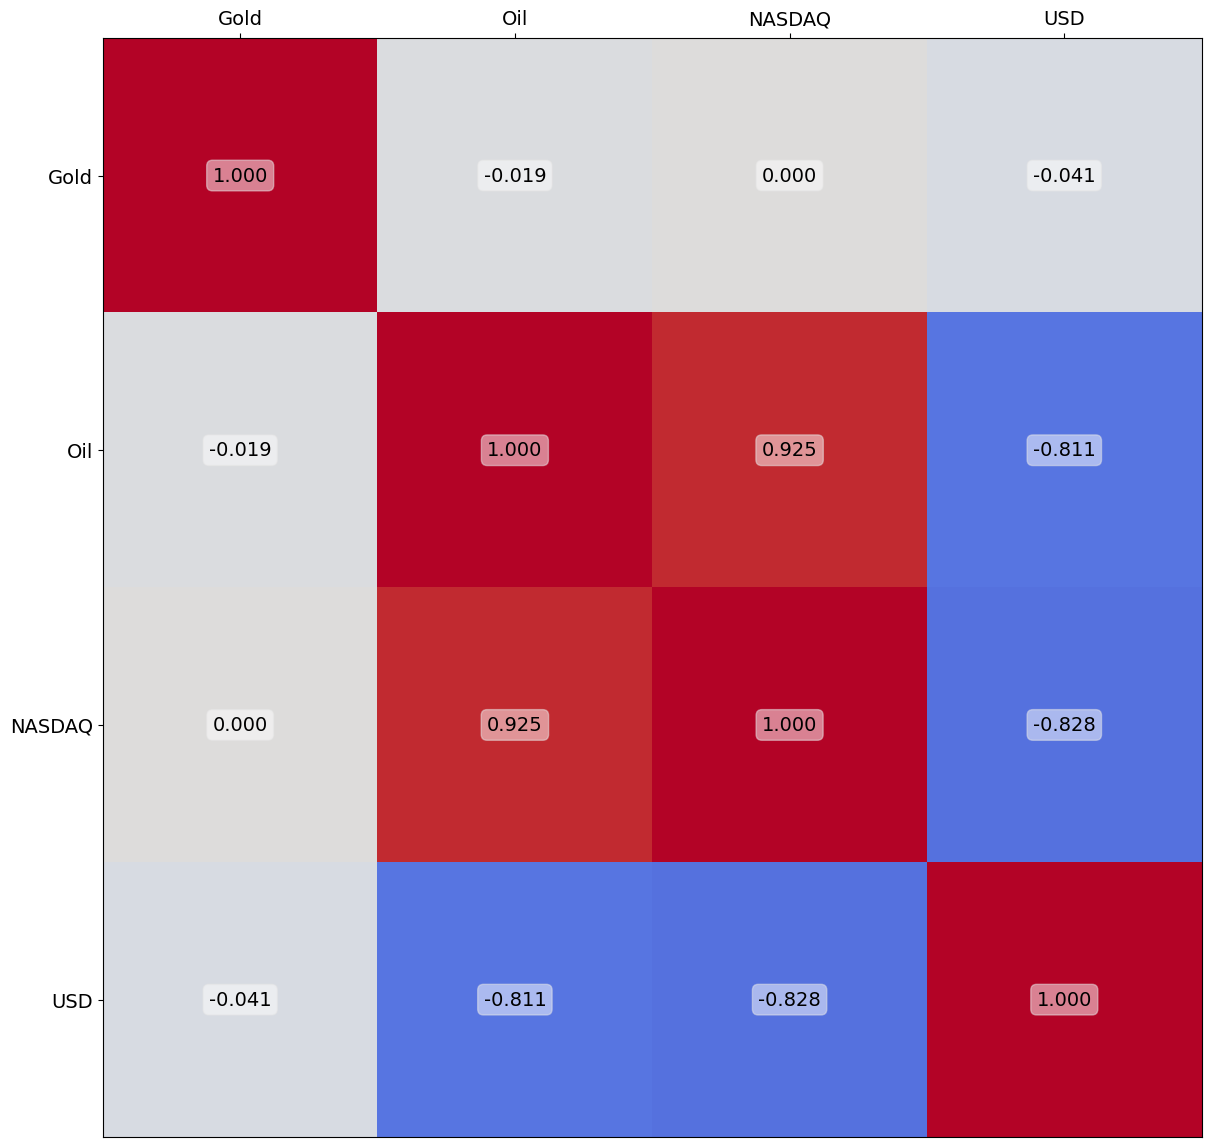

In [7]:
best_mosm.plot_correlation();

## Cross spectral mixture kernel

In [8]:
csm_models = [None] * n_trials
csm_mae = np.zeros((n_trials,4))
csm_rmse = np.zeros((n_trials,4))
csm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    csm_dataset['Gold'].remove_randomly(pct=0.6)
    csm_dataset['Oil'].remove_randomly(pct=0.3)
    csm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    csm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=Q)
    csm.init_parameters(init_method)
    try:
        csm.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        csm_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])
    csm_models[n] = csm


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: MixtureKernel.CrossSpectralKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 34
‣ Training points: 384
‣ Iterations: 1000
     0/1000   0:00:04  loss=     220.615  error=     41667.6 (warmup)
     2/1000   0:00:29  loss=     158.443  error=     30542.9
     6/1000   0:00:30  loss=     117.814  error=       22878
   109/1000   0:00:40  loss=    -23.4975  error=     11655.5
   211/1000   0:00:50  loss=     -52.818  error=       11558
   313/1000   0:01:00  loss=     -55.611  error=     11708.5
   414/1000   0:01:10  loss=    -56.9768  error=     11596.6
   514/1000   0:01:20  loss=    -57.7471  error=     11478.4
   614/1000   0:01:30  loss=    -58.3022  error=     11498.7
   714/1000   0:01:40  loss=    -58.6167  error=     11388.7
   816/1000   0:01:50  loss=    -58.9729  error=     11411.7
   917/1000   0:02:00  loss=    -59.1639  error=     11422.7
  1000/1000   0:02:08  loss=    -59.2387  e

In [9]:
pd.DataFrame(np.c_[csm_mae.mean(1), csm_rmse.mean(1), csm_mape.mean(1),
             csm_mae.std(1), csm_rmse.std(1), csm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,44.948001,61.785963,2.987471,57.883437,80.950641,1.739574
1,54.118773,69.509959,3.533615,76.228567,98.278448,2.595142
2,49.682330,63.506726,3.239904,64.780998,83.338995,1.925314


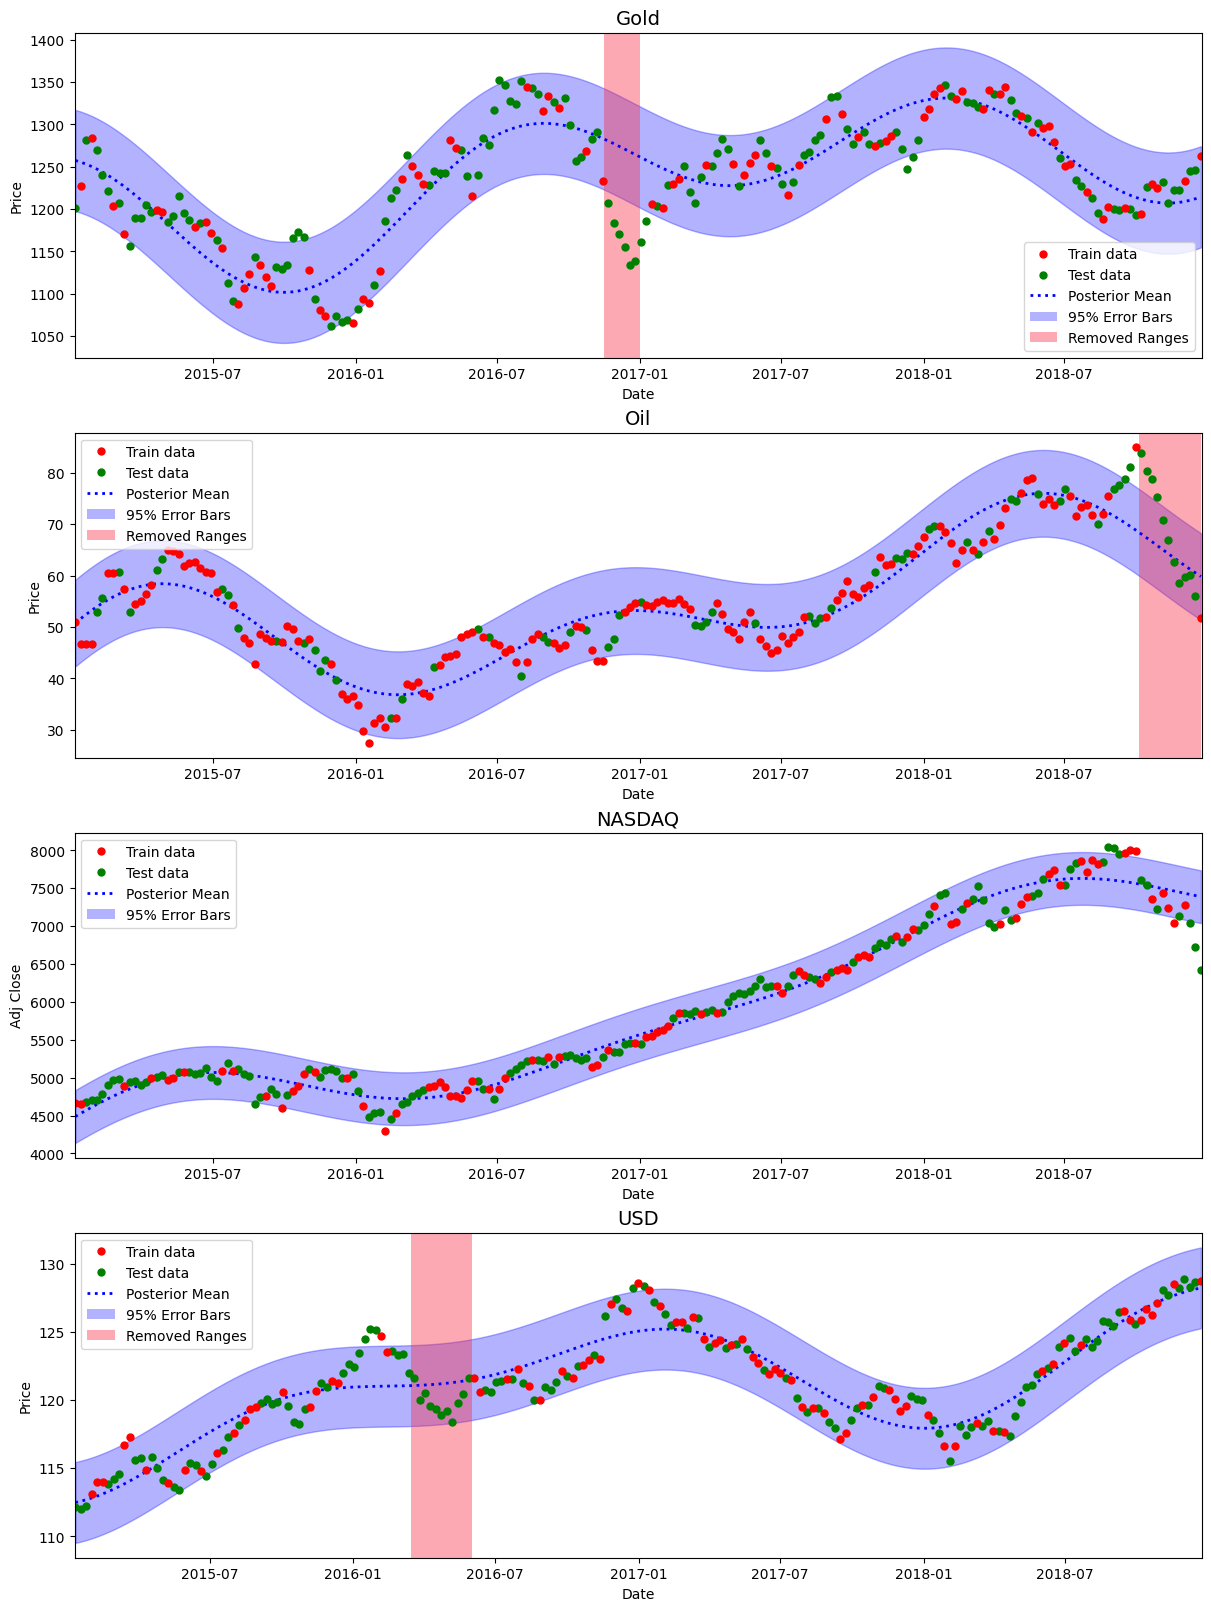

In [10]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.plot_prediction();

## Linear model of coregionalization with spectral mixture kernels

In [11]:
smlmc_models = [None] * n_trials
smlmc_mae = np.zeros((n_trials,4))
smlmc_rmse = np.zeros((n_trials,4))
smlmc_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    smlmc_dataset['Gold'].remove_randomly(pct=0.6)
    smlmc_dataset['Oil'].remove_randomly(pct=0.3)
    smlmc_dataset['NASDAQ'].remove_randomly(pct=0.6)
    smlmc_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=Q)
    smlmc.init_parameters(init_method)
    try:
        smlmc.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        smlmc_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])
    smlmc_models[n] = smlmc


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: LinearModelOfCoregionalizationKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 22
‣ Training points: 380
‣ Iterations: 1000
     0/1000   0:00:03  loss=     227.008  error=     30871.6 (warmup)
     2/1000   0:00:23  loss=     222.649  error=     29380.3
   104/1000   0:00:30  loss=     59.8922  error=     15159.1
   250/1000   0:00:40  loss=    -17.1674  error=     16172.6
   395/1000   0:00:50  loss=    -29.2801  error=     20512.8
   542/1000   0:01:00  loss=     -31.702  error=       20993
   692/1000   0:01:10  loss=    -33.0256  error=     20924.2
   837/1000   0:01:20  loss=    -33.9135  error=       20824
   984/1000   0:01:30  loss=    -34.6284  error=     20598.6
  1000/1000   0:01:31  loss=    -34.7161  error=     20550.8
Optimization finished in 1 minute 31 seconds

Trial 2 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: LinearModelOfCoregionalizationKernel
  ‣ Li

In [12]:
pd.DataFrame(np.c_[smlmc_mae.mean(1), smlmc_rmse.mean(1), smlmc_mape.mean(1),
             smlmc_mae.std(1), smlmc_rmse.std(1), smlmc_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,61.395565,78.357728,3.026545,88.255683,112.657516,1.592666
1,65.745932,81.498827,3.043165,97.120402,119.415461,1.601654
2,48.421477,61.084757,2.775707,54.390787,69.513681,1.353031


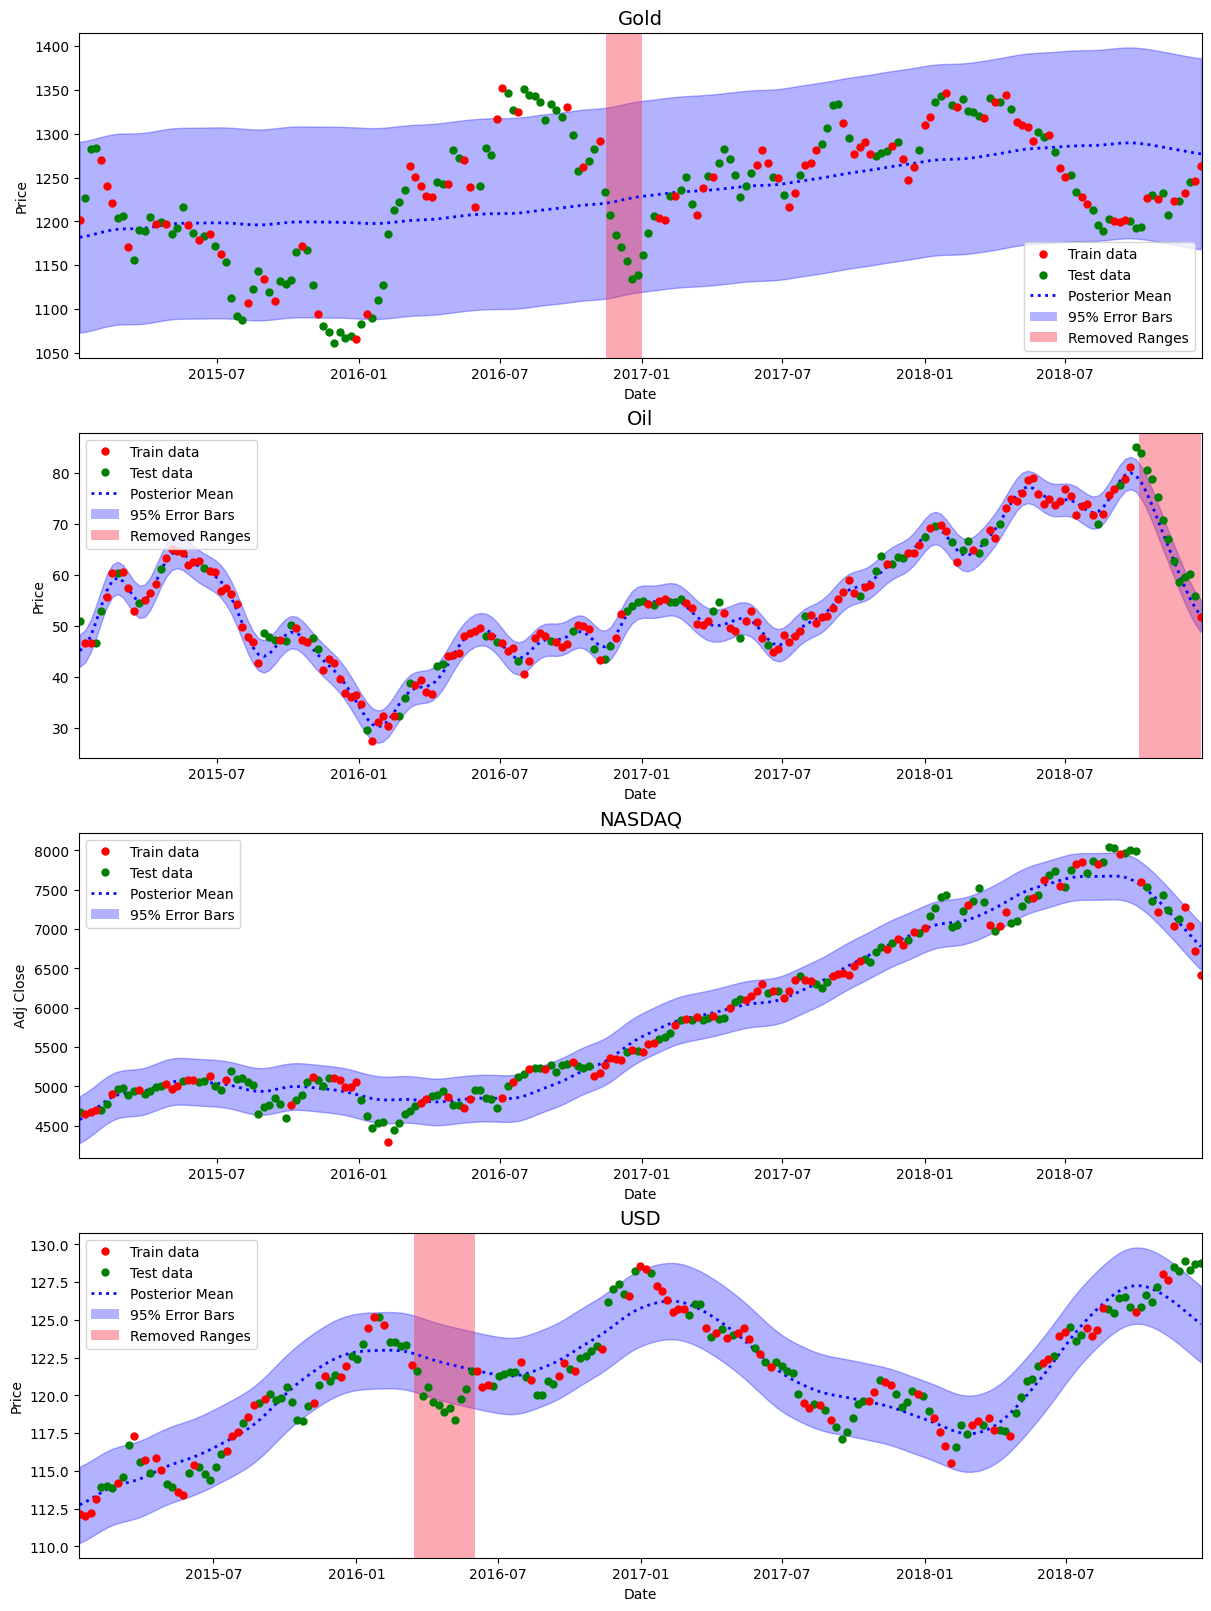

In [13]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.plot_prediction();

# Independent spectral mixture kernels

In [14]:
sm_models = [None] * n_trials
sm_mae = np.zeros((n_trials,4))
sm_rmse = np.zeros((n_trials,4))
sm_mape = np.zeros((n_trials,4))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    sm_dataset['Gold'].remove_randomly(pct=0.6)
    sm_dataset['Oil'].remove_randomly(pct=0.3)
    sm_dataset['NASDAQ'].remove_randomly(pct=0.6)
    sm_dataset['USD'].remove_randomly(pct=0.6)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=Q)
    sm.init_parameters(init_method)
    try:
        sm.train(method=method, lr=lr, iters=iters, verbose=True, error='MSE')
    except mogptk.CholeskyException:
        sm_mape[n,:] = 100.0
        continue
    finally:
        print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])
    sm_models[n] = sm


Trial 1 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: IndependentMultiOutputKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 40
‣ Training points: 385
‣ Iterations: 1000
     0/1000   0:00:01  loss=     142.118  error=     8587.79 (warmup)
    39/1000   0:00:10  loss=     80.9799  error=     9326.41
   197/1000   0:00:20  loss=    -40.7433  error=     8575.36
   367/1000   0:00:30  loss=    -113.159  error=     5910.84
   680/1000   0:00:40  loss=    -149.666  error=     5884.36
   974/1000   0:00:50  loss=    -160.171  error=      5861.8
  1000/1000   0:00:50  loss=    -160.797  error=     5860.67
Optimization finished in 50.927 seconds

Trial 2 of 3
Starting optimization using Adam
‣ Model: Exact
  ‣ Kernel: IndependentMultiOutputKernel
  ‣ Likelihood: GaussianLikelihood
‣ Channels: 4
‣ Parameters: 40
‣ Training points: 384
‣ Iterations: 1000
     0/1000   0:00:01  loss=     142.883  error=     10181.9 (warmup)
    91/1000   0:00:10  loss=    

In [15]:
pd.DataFrame(np.c_[sm_mae.mean(1), sm_rmse.mean(1), sm_mape.mean(1),
             sm_mae.std(1), sm_rmse.std(1), sm_mape.std(1)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,34.163077,44.352772,1.864231,44.362944,57.479050,0.887819
1,34.815029,45.856551,2.821572,44.702606,58.932788,2.378532
2,42.272163,57.684126,3.050305,56.659901,77.843826,2.264836


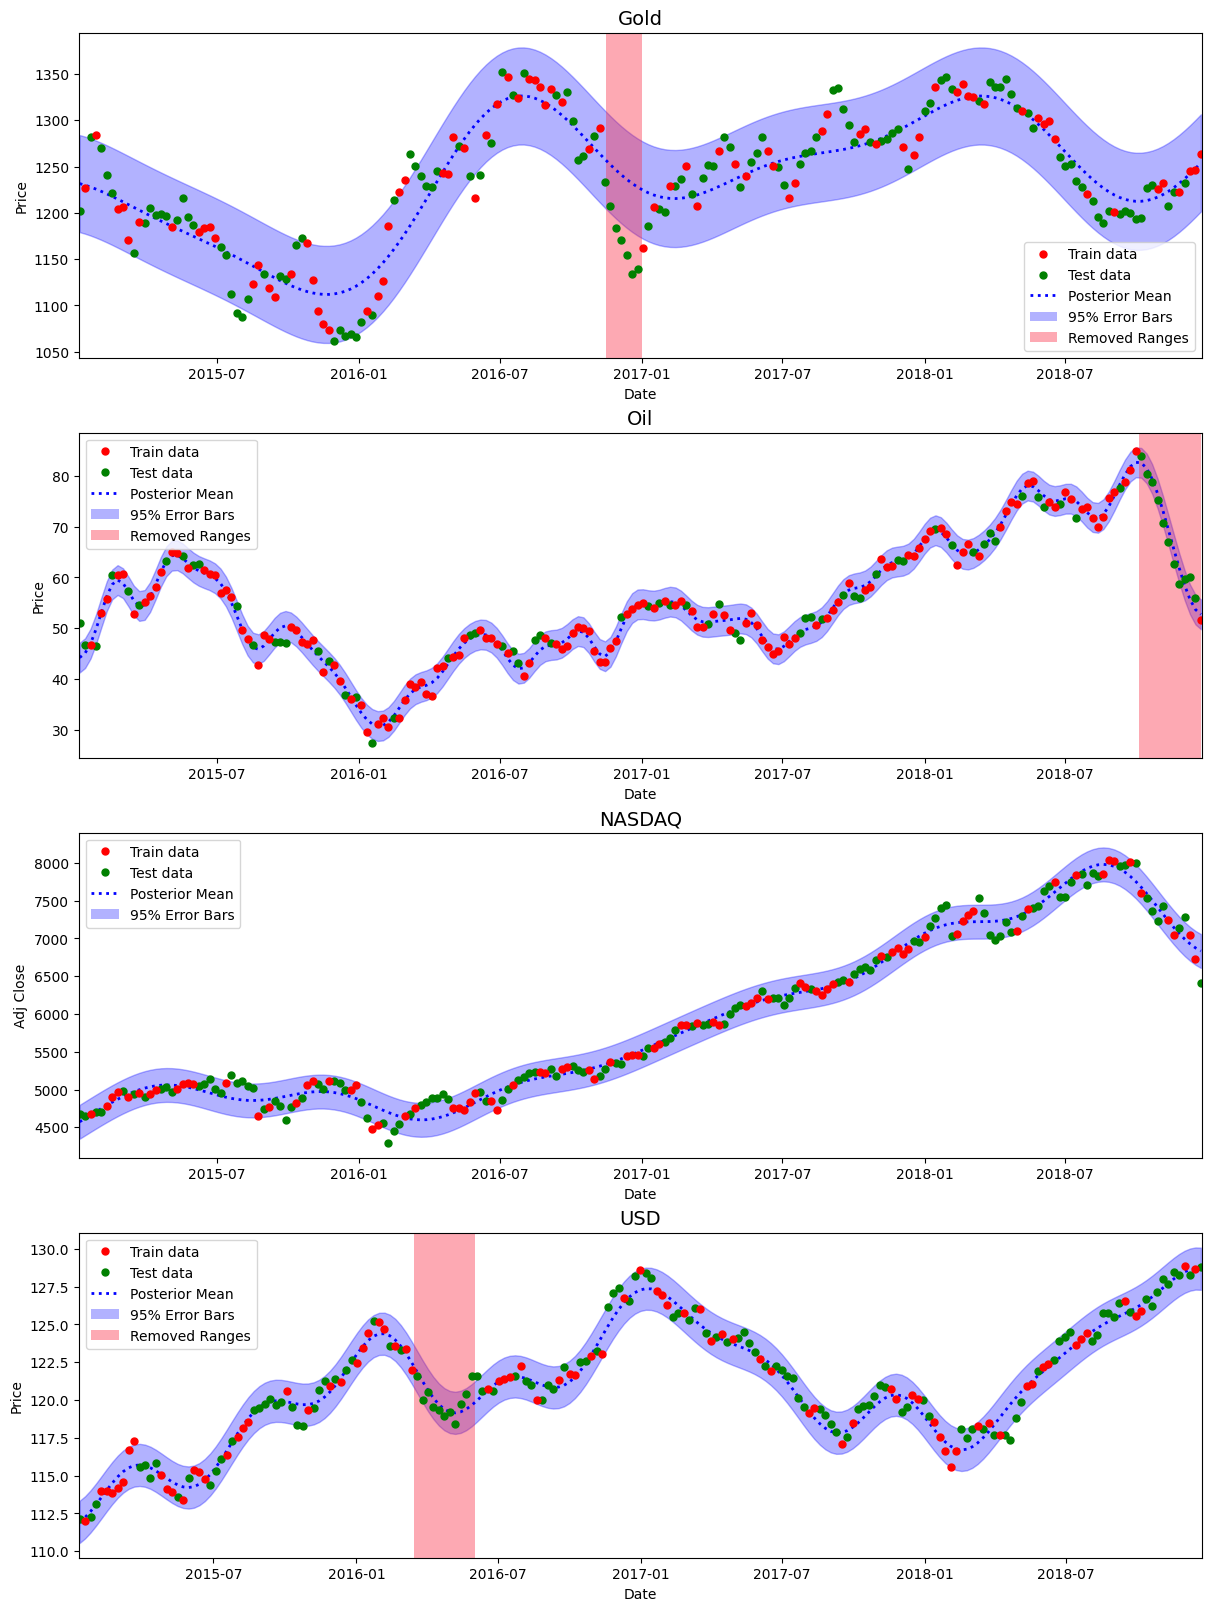

In [16]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.plot_prediction();

## Results

In [17]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))

MAPE errors per model
MOSM:    3.05872 ± 0.206108
CSM:     3.25366 ± 0.223175
SM-LMC:  2.94847 ± 0.122352
SM:      2.5787 ± 0.513765
